In [6]:
import pandas as pd
import numpy as np
import pickle
import networkx as nx
from functools import partial
from operator import itemgetter
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from QAOAKit.utils import maxcut_obj, get_adjacency_matrix

In [2]:
df = pd.read_pickle("../data.p")

In [2]:
def load_graph(gname, type_name, target_nnodes=None):
    G = nx.read_weighted_edgelist(f'../graphs/{gname}/{type_name}')
    G = nx.relabel_nodes(G, {x: int(x) for x in G.nodes})
    if target_nnodes is not None:
        assert G.number_of_nodes() <= target_nnodes
        if G.number_of_nodes() < target_nnodes:
            for n in range(target_nnodes):
                if n not in G.nodes:
                    G.add_node(n)
    assert set(G.nodes) == set(range(G.number_of_nodes()))
    return G

def brute_force(obj_f, num_variables, minimize=False):
    """Get the maximum of a function by complete enumeration
    Returns the maximum value and the extremizing bit string
    """
    if minimize:
        best_cost_brute = float("inf")
        compare = lambda x, y: x < y
    else:
        best_cost_brute = float("-inf")
        compare = lambda x, y: x > y
    bit_strings = (
        (
            (
                np.array(range(2 ** num_variables))[:, None]
                & (1 << np.arange(num_variables))
            )
        )
        > 0
    ).astype(int)
    xbest_brute = set()
    for x in bit_strings:
        cost = obj_f(np.array(x))
        x = ''.join(str(y) for y in x)
        if np.isclose(cost, best_cost_brute):
            xbest_brute.add(x)
        elif compare(cost, best_cost_brute):
            best_cost_brute = cost
            xbest_brute.clear()
            xbest_brute.add(x)
    return best_cost_brute, xbest_brute

def brute_force_wrap(G):
    obj = partial(maxcut_obj, w=get_adjacency_matrix(G))
    return brute_force(obj, G.number_of_nodes())

In [3]:
def get_energy_levels(obj_f, num_variables, minimize=False):
    """Get the energy levels of a function by complete enumeration
    """
    if minimize:
        best_cost_brute = float("inf")
        compare = lambda x, y: x < y
    else:
        best_cost_brute = float("-inf")
        compare = lambda x, y: x > y
    bit_strings = (
        (
            (
                np.array(range(2 ** num_variables))[:, None]
                & (1 << np.arange(num_variables))
            )
        )
        > 0
    ).astype(int)
    spectrum = defaultdict(set)
    for x in bit_strings:
        cost = obj_f(np.array(x))
        assert np.isclose(cost, int(cost))
        cost = int(cost)
        x = ''.join(str(y) for y in x)
        spectrum[cost].add(x)
    return spectrum


def get_energy_levels_wrap(G):
    obj = partial(maxcut_obj, w=get_adjacency_matrix(G))
    return get_energy_levels(obj, G.number_of_nodes())

Text(0.5, 0.98, '')

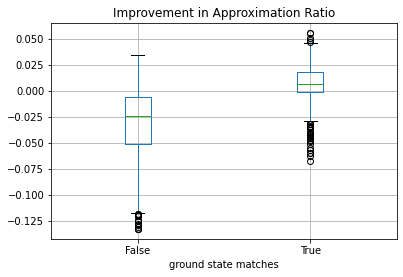

In [107]:
import matplotlib.pyplot as plt
df.boxplot('Improvement in Approximation Ratio', by='ground state matches')
plt.suptitle('')

In [ ]:
df['nx_G'] = df.apply(
    lambda row: load_graph(row['G'], 'graph'),
    axis = 1
)

In [33]:
df['nx_S'] = df.apply(
    lambda row: load_graph(row['G'], row['S'], target_nnodes=row['nx_G'].number_of_nodes()),
    axis = 1
)

In [5]:
df[[
    'opt cost G', 
    'opt strs G',
]] = df.progress_apply(
    lambda row: brute_force_wrap(row['nx_G']),
    axis=1,
    result_type='expand'
)

100%|██████████| 1836/1836 [09:10<00:00,  3.33it/s]


In [35]:
assert all(df['opt'] == df['opt cost G'])

In [34]:
df[[
    'opt cost S', 
    'opt strs S',
]] = df.progress_apply(
    lambda row: brute_force_wrap(row['nx_S']),
    axis=1,
    result_type='expand'
)

100%|██████████| 1836/1836 [10:09<00:00,  3.01it/s]


In [89]:
df['ground state matches'] = df.apply(
    lambda row: row['opt strs S'].issubset(row['opt strs G']) or row['opt strs G'].issubset(row['opt strs S']),
    axis = 1
)

In [101]:
df['Improvement in Approximation Ratio'] = df['rho_S'] - df['rho_G']

Text(0.5, 0.98, '')

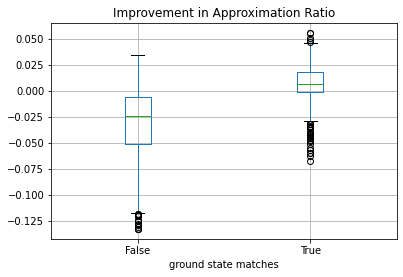

In [107]:
import matplotlib.pyplot as plt
df.boxplot('Improvement in Approximation Ratio', by='ground state matches')
plt.suptitle('')

In [110]:
df['ground state energy matches'] = df.apply(
    lambda row: np.isclose(row['opt cost G'], row['opt cost S']),
    axis = 1
)

Text(0.5, 0.98, '')

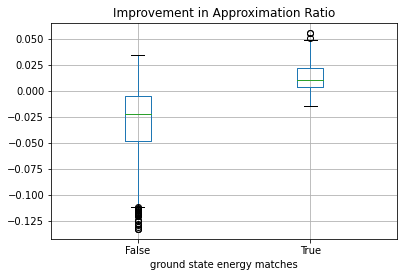

In [111]:
import matplotlib.pyplot as plt
df.boxplot('Improvement in Approximation Ratio', by='ground state energy matches')
plt.suptitle('')

In [177]:
# df.to_pickle('../data_processed_with_full_spectrum.p')
# df = pd.read_pickle('../data_processed.p')

In [164]:
df['spectrum G'] = df.progress_apply(
    lambda row: get_energy_levels_wrap(row['nx_G']),
    axis=1,
)

100%|██████████| 1836/1836 [09:45<00:00,  3.14it/s]


In [165]:
df['spectrum S'] = df.progress_apply(
    lambda row: get_energy_levels_wrap(row['nx_S']),
    axis=1,
)

100%|██████████| 1836/1836 [09:31<00:00,  3.21it/s]


In [166]:
assert df.apply(
    lambda row: max(row['spectrum G'].keys()) == row['opt cost G'],
    axis = 1
).all()

assert df.apply(
    lambda row: max(row['spectrum S'].keys()) == row['opt cost S'],
    axis = 1
).all()

assert df.apply(
    lambda row: row['spectrum G'][int(row['opt cost G'])] == row['opt strs G'],
    axis = 1
).all()

assert df.apply(
    lambda row: row['spectrum S'][int(row['opt cost S'])] == row['opt strs S'],
    axis = 1
).all()

In [167]:
df['energy spectrum G'] = df.apply(
    lambda row: sorted(row['spectrum G'].keys(), reverse=True),
    axis = 1,
)
df['energy spectrum S'] = df.apply(
    lambda row: sorted(row['spectrum S'].keys(), reverse=True),
    axis = 1,
)

In [168]:
def number_of_matching_energy_levels(spectrum1, spectrum2):
    num_matching = 0
    for idx, (v1,v2) in enumerate(zip(spectrum1, spectrum2)):
        if not np.isclose(v1,v2):
            break
        num_matching += 1
    assert num_matching <= min(len(spectrum1), len(spectrum2))
    return num_matching

In [169]:
df['num matching energy levels'] = df.apply(
    lambda row: number_of_matching_energy_levels(row['energy spectrum G'], row['energy spectrum S']),
    axis = 1,
)

Text(0.5, 0.98, '')

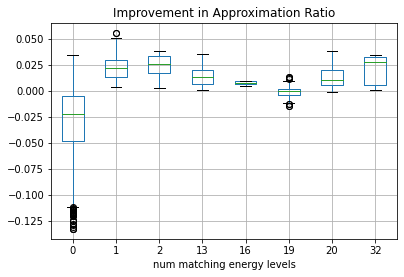

In [170]:
df.boxplot('Improvement in Approximation Ratio', by='num matching energy levels')
plt.suptitle('')

In [171]:
df['ratio matching energy levels'] = df.apply(
    lambda row: number_of_matching_energy_levels(
        row['energy spectrum G'], row['energy spectrum S']
    ) / max(len(row['energy spectrum G']), len(row['energy spectrum S'])),
    axis = 1,
)

Text(0.5, 0.98, '')

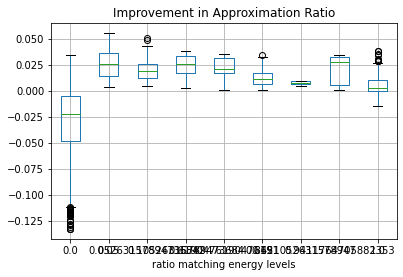

In [173]:
import matplotlib.pyplot as plt
df.boxplot('Improvement in Approximation Ratio', by='ratio matching energy levels')
plt.suptitle('')

Text(0.5, 0.98, '')

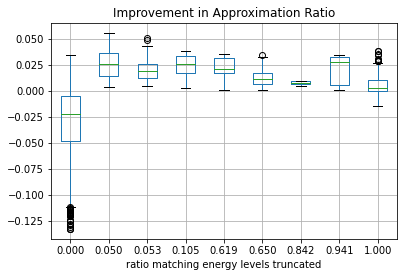

In [175]:
df['ratio matching energy levels truncated'] = df.apply(
    lambda row: f"{row['ratio matching energy levels']:.3f}",
    axis =1 
)
df.boxplot('Improvement in Approximation Ratio', by='ratio matching energy levels truncated')
plt.suptitle('')

# Generate the figure

In [4]:
df = pd.read_pickle('../data_processed.p')

In [7]:
df['state spectrum G'] = df.apply(
    lambda row: [x[1] for x in sorted(row['spectrum G'].items(), key=itemgetter(0), reverse=True)],
    axis = 1,
)
df['state spectrum S'] = df.apply(
    lambda row: [x[1] for x in sorted(row['spectrum S'].items(), key=itemgetter(0), reverse=True)],
    axis = 1,
)

In [8]:
def number_of_matching_energy_subspaces(spectrum1, spectrum2):
    num_matching = 0
    for idx, (v1,v2) in enumerate(zip(spectrum1, spectrum2)):
        if not v1.issubset(v2):
            break
        num_matching += 1
    assert num_matching <= min(len(spectrum1), len(spectrum2))
    return num_matching

In [12]:
df['Number of aligned energy levels'] = df.apply(
    lambda row: number_of_matching_energy_subspaces(row['state spectrum S'], row['state spectrum G']),
    axis = 1,
)

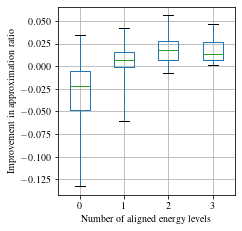

In [20]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(6.92654/2, 6.92654/2))

df.boxplot('Improvement in Approximation Ratio', by='Number of aligned energy levels', ax=ax, whis=(0,100))
plt.suptitle('')
plt.title('')
plt.ylabel('Improvement in approximation ratio')
plt.tight_layout()
plt.savefig('energy_lvl_alignment.pdf')

In [190]:
for x in set(df['num matching energy subspaces']):
    print(sum(df['num matching energy subspaces'] == x))

1449
261
108
18


In [16]:
!open .